# Silvereye Access with OWSLib-WPS  (2020-10-15)

This page demonstrates how to use the `owslib.wps` Python library to invoke our *SilverEye WPS microservice*. 

In [1]:
from owslib.wps import WebProcessingService
wps = WebProcessingService('https://api.silvereye.bccvl.org.au/wps', verbose=False, skip_caps=True)
wps.getcapabilities()
wps.identification.type

'WPS'

In [2]:
wps.identification.title

'PyWPS Processing Service'

In [3]:
wps.identification.abstract

'PyWPS is an implementation of the Web Processing Service standard from the Open Geospatial Consortium. PyWPS is written in Python.'

In [4]:
for operation in wps.operations:
    print(operation.name)

GetCapabilities
DescribeProcess
Execute


## What processes are supported?

In [5]:
for process in wps.processes:
    print("{:>30}: {}".format(process.identifier, process.title))

   process_one_year_all_months: ANUClim monthly aggregation for all months in one year.
 process_one_year_all_quarters: ANUClim quarterly aggregation for one whole year.
  process_one_year_month_range: ANUClim monthly aggregation within range of months in one year.
    process_one_year_one_month: ANUClim monthly aggregation for one month in one year.
  process_one_year_one_quarter: ANUClim quarterly aggregation for one quarter in one year.
      process_years_all_months: ANUClim monthly aggregation for all months in a range of years.
    process_years_all_quarters: ANUClim quarterly aggregation for a range of years.
       process_years_one_month: ANUClim monthly aggregation for only one month in a range of years.
     process_years_one_quarter: ANUClim quarterly aggregation for one quarter in a range of years.
              process_one_year: ANUClim yearly aggregation for one year.
                 process_years: ANUClim yearly aggregation for a range of years.
process_from_year_month

## Getting Process Descriptions

In [6]:
from owslib.wps import printInputOutput
process = wps.describeprocess('one_wps_process')
process.identifier

'one_wps_process'

In [7]:
process.title

'SilverEye combined process for multiple spatial and time selections.'

In [8]:
process.abstract

"Single entry point for all of SilverEye's functions."

In [9]:
for input in process.dataInputs:
    printInputOutput(input)
    print()

 identifier=spatial_selection_type, title=Type of selection in space, abstract=None, data type=string
 Allowed Value: rectangular_region
 Allowed Value: single_location
 Allowed Value: predefined_region
 Allowed Value: polygon
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=time_selection_type, title=Type of selection in time, abstract=None, data type=string
 Allowed Value: one_year_one_month
 Allowed Value: one_year_all_months
 Allowed Value: one_year_month_range
 Allowed Value: from_yrmo_to_yrmo_range
 Allowed Value: years_one_month
 Allowed Value: years_all_months
 Allowed Value: years_month_range
 Allowed Value: years_one_quarter
 Allowed Value: years_all_quarters
 Allowed Value: one_year_one_quarter
 Allowed Value: one_year_all_quarters
 Allowed Value: one_year
 Allowed Value: years
 Default Value: None 
 minOccurs=1, maxOccurs=1

 identifier=variables, title=Variables to extract, abstract=None, data type=string
 Allowed Value: temp_max
 Allowed Value: temp_min
 Allow

In [10]:
for output in process.processOutputs:
    printInputOutput(output)

 identifier=output, title=Metadata, abstract=None, data type=ComplexData
 Supported Value: mimeType=application/zip, encoding=None, schema=None
 Default Value: mimeType=application/zip, encoding=None, schema=None 
 reference=None, mimeType=None


## Understanding the SilverEye Unified WPS API

SilverEye's WPS API was growing very quickly and getting more complex, so we decided to create a unified, one WPS API. 
 It is identified by the processid `one_wps_process`.

Next, you need to specify one or more climatic `variables`, from a choice of: `temp_min`, `temp_max`, `rainfall`, `solar_radiation`, `vapour_pressure`.

You also need to specify a statistical function, with the `stfn` parameter name, with a choice of: `min`, `mean`, `median`, `max`, `std` (standard deviation), or `var` (variance).

We have 4 types of spatial selections, and 13 types of time selections ( 4 x 13 = 52 combinations). Each have related parameters that must be specified.

To specify a spatial selection, you use the parameter `spatial_selection_type`. The options are: `rectangular_region`, `predefined_region`, `single_location`, `polygon`.

|Spatial Selection Type|Associated Parameters|
|-----------------|--------------------|
|rectangular_region|lat_min, lat_max, lon_min, lon_max|
|single_location|lat, lon|
|predefined_region|gdb_name, rec_id|
|polygon|geometry|

If you choose the `single_location`, for example, then you need to specify the variables `lat` and `lon`, as shown above.

To specify a time selection, you use the parameter `time_selection_type`. It may take one of the following 13 values:

|Time Selection Type|Associated Parameters|
|-----------------|--------------------|
|one_year_one_month|year, month|
|one_year_all_months|year|
|years_one_month|year_min, year_max, month|
|years_all_months|year_min, year_max|
|one_year_one_quarter|year, quarter|
|one_year_all_quarters|year|
|years_one_quarter|year_min, year_max, quarter|
|years_all_quarters|year_min, year_max|
|one_year_month_range|year, month_min, month_max|
|years_month_range|year_min, year_max, month_min, month_max|
|from_yrmo_to_yrmo_range|year_from, month_from, year_to, month_to|
|one_year|year|
|years|year_min, year_max|

If you choose the `one_year_one_month`, for example, then additionally, you need to specify the variables `year` and `month`, as shown above.



## Execute a Rectangular Region Process

Before we submit a process for execution, lets define a function to allow us to monitor the execution.


In [11]:
def monitor_execution(execution, sleepSecs=5, download=False, filepath='data/out.zip'):
    while execution.isComplete() is False:
        execution.checkStatus(sleepSecs=sleepSecs)
        print('Execution status: {}'.format(execution.statusMessage))

    if execution.isSucceded():
        if download:
            execution.getOutput(filepath=filepath)
        else:
            for output in execution.processOutputs:
                if output.reference is not None:
                    print('Output URL={}'.format(output.reference))
    else:
        for ex in execution.errors:
            print('Error: code={}, locator={}, text={}'.format(ex.code, ex.locator, ex.text))

The parameters are the following:
- `execution`: the wps process we submitted
- `sleepSecs`: how often to report the status (in seconds)
- `download`: if we want to download the result, then use `filepath`; otherwise, report a URL.
- `filepath`: path to where we want to store the result

If the execution terminated with errors, they will be listed. 

Now we are ready to submit our first process. 

In [12]:
processid = 'one_wps_process'
inputs = [
    ("variables", "temp_max"), ("variables", "temp_min"), ("variables", "rainfall"),
    ("stfn", "mean"),
    ("spatial_selection_type", "rectangular_region"),
    ("lat_min", "-28.135"), ("lat_max", "-28.105"),
    ("lon_min", "152.855"), ("lon_max", "152.875"),
    ("time_selection_type", "one_year_one_month"),
    ("year", "2014"), ("month", "6")   
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

Monitor the execution by calling the function. 

In [13]:
monitor_execution(execution, sleepSecs=10, download=True, filepath='data/outputs/out20201015T0912.zip')

Execution status: PyWPS Process one_wps_process accepted
Execution status: PyWPS Process started
Execution status: PyWPS Process SilverEye combined process for multiple spatial and time selections. finished


In [14]:
filepath = 'data/outputs/out20201015T0912.zip'

Now let's examine the contents of our resulting ZIP file.

In [15]:
from zipfile import ZipFile
f = ZipFile(filepath)
print(f.namelist())
f.close()

['result.zarr', 'metadata.json', 'rainfall.csv', 'temp_min.csv', 'temp_min.tif', 'temp_max.tif', 'rainfall.tif', 'temp_max.csv', 'result.csv', 'result.nc']


### Process NetCDF File

Lets extract the `result.nc` (NetCDF) file, open it as an xarray dataset, and examine its contents.

In [16]:
# now we read the result
import xarray as xr

with ZipFile(filepath) as z:
    with z.open('result.nc') as zf:
        xds = xr.load_dataset(zf.read())
xds

<xarray.Dataset>
Dimensions:   (lat: 4, lon: 3, time: 1)
Coordinates:
  * lat       (lat) float64 -28.11 -28.11 -28.12 -28.14
  * lon       (lon) float64 152.9 152.9 152.9
  * time      (time) datetime64[ns] 2014-06-01
Data variables:
    rainfall  (time, lat, lon) float32 0.6808464 0.6700856 ... 0.61339635
    temp_min  (time, lat, lon) float32 7.1886106 7.2265573 ... 7.1756883
    temp_max  (time, lat, lon) float32 21.640259 21.457794 ... 21.940153 22.0892
Attributes:
    geospatial_lat_min:         -28.105
    geospatial_lat_max:         -28.135
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.855
    geospatial_lon_max:         152.875
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    licence_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ATMOSPHERE
    summary:                    ANU Daily Data Cubes Sliced and Aggregated
    spatial_coverage:           Australia
    acknowledgement:            The creation of this data was funded by ecoCo...
    title:                      ANU Daily Data Cubes Aggregated
    institution:                Griffith University, Queensland
    contributor_name:           Silvereye, ecoCommons
    license:                    Attribution 4.0 International
    cdm_data_type:              grid
    contact:                    ecocommons@ecocommons.org.au
    source:                     ANUClimate_v1_1
    date_created:               2020-10-27
    publisher_name:             Silvereye microservice, ecoCommons Australia
    publisher_url:              https://ecocommons.org.au
    publisher_email:            ecocommons@ecocommons.org.au

We can see that it contains the following data variables: `rainfall`, `temp_max`, `temp_min`.
It also contains one time value: `2014-06-01`.
Lets plot a 2d image of the `temp_max` variable. 

In [17]:
import xarray as xr
from matplotlib import pyplot as plt

xds['temp_max'].sel({'time': '2014-06-01'}).plot()

### Process CSV File

Now, lets open the `result.csv` file and examine it with Pandas.

In [18]:
# now we read the result
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df.head()

,lat,lon,time,rainfall,temp_min,temp_max
0,-28.105,152.855,2014-06-01,0.680846,7.188611,21.640259
1,-28.105,152.865,2014-06-01,0.670086,7.226557,21.457794
2,-28.105,152.875,2014-06-01,0.659532,7.238303,22.230024
3,-28.115,152.855,2014-06-01,0.666355,7.171170,22.126766
4,-28.115,152.865,2014-06-01,0.654074,7.189524,22.104393


Lets plot some `rainfall` values along different `latitudes` ...

<AxesSubplot:title={'center':'Rainfall means for 2014-06'}, xlabel='lat'>

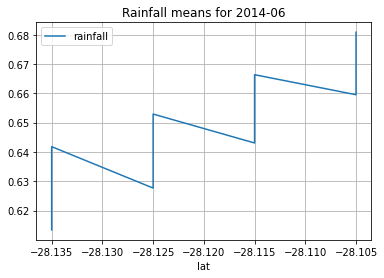

In [19]:
df.plot('lat', 'rainfall', kind='line', title='Rainfall means for 2014-06', grid=True)


### Process Metadata File

Now lets open the `metadata.json` file, and examine its contents.

In [20]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))
    

{
    "spatial_selection_type": "rectangular_region",
    "process_name": "process_one_year_one_month",
    "variables": [
        "rainfall",
        "temp_min",
        "temp_max"
    ],
    "time_selection": {
        "stfn": "mean",
        "yr": 2014,
        "mo": 6,
        "xly": "monthly"
    },
    "bounds": {
        "lat_min": -28.135,
        "lat_max": -28.105,
        "lon_min": 152.855,
        "lon_max": 152.875
    }
}


### Process TIFF File

In [21]:
import rasterio as rio

with ZipFile(filepath) as z:
    tf = z.extract('temp_max.tif', path='data/outputs')
    rds = rio.open(tf)
        
data = {  # gather all the attrs together
    'meta': rds.meta,
    'bounds': rds.bounds,
    'resolution': rds.res,
    'tags': rds.tags, 
    'indexes': rds.indexes,
    'name': rds.name, 
    'mode': rds.mode
}
data  # notice count: 1, means 1 layer

{'meta': {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': None,
  'width': 3,
  'height': 4,
  'count': 1,
  'crs': CRS.from_epsg(4462),
  'transform': Affine(0.010000000000005116, 0.0, 152.85,
         0.0, -0.010000000000000378, -28.1)},
 'bounds': BoundingBox(left=152.85, bottom=-28.140000000000004, right=152.88, top=-28.1),
 'resolution': (0.010000000000005116, 0.010000000000000378),
 'tags': <function DatasetReader.tags>,
 'indexes': (1,),
 'name': 'data/outputs/temp_max.tif',
 'mode': 'r'}

In [22]:
rds.read(1)  # returns numpy array  # read layer 1

array([[21.640259, 21.457794, 22.230024],
       [22.126766, 22.104393, 22.238274],
       [22.113098, 22.146233, 22.215727],
       [21.950369, 21.940153, 22.0892  ]], dtype=float32)

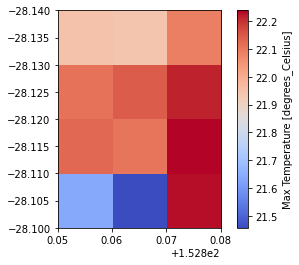

In [23]:
from matplotlib import pyplot as plt

axs = plt.imshow(rds.read(1), cmap='coolwarm', origin='lower',
                 extent=(rds.bounds.left, rds.bounds.right, rds.bounds.top, rds.bounds.bottom))
plt.colorbar(label='Max Temperature [degrees_Celsius]')
plt.show()

### Zarr File

In [24]:
import xarray as xr
import zarr

with ZipFile(filepath) as z:
    zf = z.extract('result.zarr', path='data/outputs')
    store = zarr.ZipStore(zf, mode='r')
    ds = xr.open_zarr(store)
ds

<xarray.Dataset>
Dimensions:   (lat: 4, lon: 3, time: 1)
Coordinates:
  * lat       (lat) float64 -28.11 -28.11 -28.12 -28.14
  * lon       (lon) float64 152.9 152.9 152.9
  * time      (time) datetime64[ns] 2014-06-01
Data variables:
    rainfall  (time, lat, lon) float32 ...
    temp_max  (time, lat, lon) float32 ...
    temp_min  (time, lat, lon) float32 ...
Attributes:
    DOI:                        to be added
    acknowledgement:            The creation of this data was funded by ecoCo...
    cdm_data_type:              grid
    contact:                    ecocommons@ecocommons.org.au
    contributor_name:           Silvereye, ecoCommons
    date_created:               2020-10-27
    geospatial_lat_max:         -28.135
    geospatial_lat_min:         -28.105
    geospatial_lat_resolution:  0.01
    geospatial_lat_units:       degrees_north
    geospatial_lon_max:         152.875
    geospatial_lon_min:         152.855
    geospatial_lon_resolution:  0.01
    geospatial_lon_units:       degrees_east
    institution:                Griffith University, Queensland
    keywords:                   EARTH SCIENCE > ATMOSPHERE
    licence_data_access:        These data can be freely downloaded and used
    license:                    Attribution 4.0 International
    publisher_email:            ecocommons@ecocommons.org.au
    publisher_name:             Silvereye microservice, ecoCommons Australia
    publisher_url:              https://ecocommons.org.au
    source:                     ANUClimate_v1_1
    spatial_coverage:           Australia
    summary:                    ANU Daily Data Cubes Sliced and Aggregated
    title:                      ANU Daily Data Cubes Aggregated

## Executing a Single Location Process

In [25]:
processid = 'one_wps_process'
inputs = [
    ("variables", "temp_max"), ("variables", "temp_min"), ("variables", "rainfall"),
    ("stfn", "mean"),
    ("spatial_selection_type", "single_location"),
    ("lat", "-28.135"), ("lon", "152.875"),
    ("time_selection_type", "one_year_all_months"),
    ("year", "2014") 
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [26]:
monitor_execution(execution, sleepSecs=10, download=True, filepath='data/outputs/out20201015T1111.zip')

Execution status: PyWPS Process started
Execution status: process_single_location_one_year_all_months 7/36 (19%)
Execution status: process_single_location_one_year_all_months 20/36 (55%)
Execution status: process_single_location_one_year_all_months 32/36 (88%)
Execution status: PyWPS Process SilverEye combined process for multiple spatial and time selections. finished


### Process the NetCDF File

In [27]:
filepath = 'data/outputs/out20201015T1111.zip'

Lets examine the NetCDF file.

In [28]:
import xarray as xr

with ZipFile(filepath) as z:
    with z.open('result.nc') as zf:
        xds = xr.load_dataset(zf.read())
xds

<xarray.Dataset>
Dimensions:   (time: 12)
Coordinates:
  * time      (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2014-12-01
    lat       float64 -28.14
    lon       float64 152.9
Data variables:
    rainfall  (time) float32 0.72476166 0.12324161 ... 2.4187658 5.6371284
    temp_min  (time) float32 18.594612 18.26295 17.146334 ... 17.80273 18.621477
    temp_max  (time) float32 31.622938 31.050322 ... 32.10772 30.764874
Attributes:
    geospatial_lat_min:         -28.135
    geospatial_lat_max:         -28.135
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.875
    geospatial_lon_max:         152.875
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    licence_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ATMOSPHERE
    summary:                    ANU Daily Data Cubes Sliced and Aggregated
    spatial_coverage:           Australia
    acknowledgement:            The creation of this data was funded by ecoCo...
    title:                      ANU Daily Data Cubes Aggregated
    institution:                Griffith University, Queensland
    contributor_name:           Silvereye, ecoCommons
    license:                    Attribution 4.0 International
    cdm_data_type:              grid
    contact:                    ecocommons@ecocommons.org.au
    source:                     ANUClimate_v1_1
    date_created:               2020-10-27
    publisher_name:             Silvereye microservice, ecoCommons Australia
    publisher_url:              https://ecocommons.org.au
    publisher_email:            ecocommons@ecocommons.org.au

Notice the `single_location` selection has only one pair of `lat-lon` values.
There are 12 time values.
Let's plot those for the `temp_max` variable.

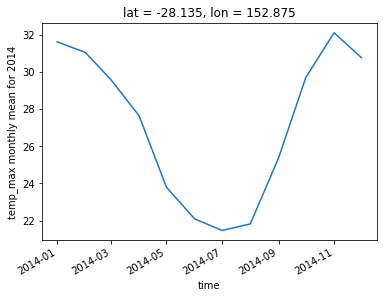

In [29]:
xds['temp_max'].plot()

### ZIP File contents

In [30]:
# show contents
from zipfile import ZipFile
f = ZipFile(filepath)
print(f.namelist())
f.close()

['temp_min.png', 'rainfall.png', 'metadata.json', 'rainfall.csv', 'temp_min.csv', 'result.png', 'temp_max.csv', 'result.csv', 'result.nc', 'temp_max.png']


Notice the absence of the `result.zarr` file.  

### Metadata Results

In [31]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))

{
    "spatial_selection_type": "single_location",
    "process_name": "process_single_location_one_year_all_months",
    "variables": [
        "rainfall",
        "temp_min",
        "temp_max"
    ],
    "time_selection": {
        "stfn": "mean",
        "yr": 2014,
        "xly": "monthly"
    },
    "coords": {
        "lat": -28.135,
        "lon": 152.875
    }
}


### Show PNG File 

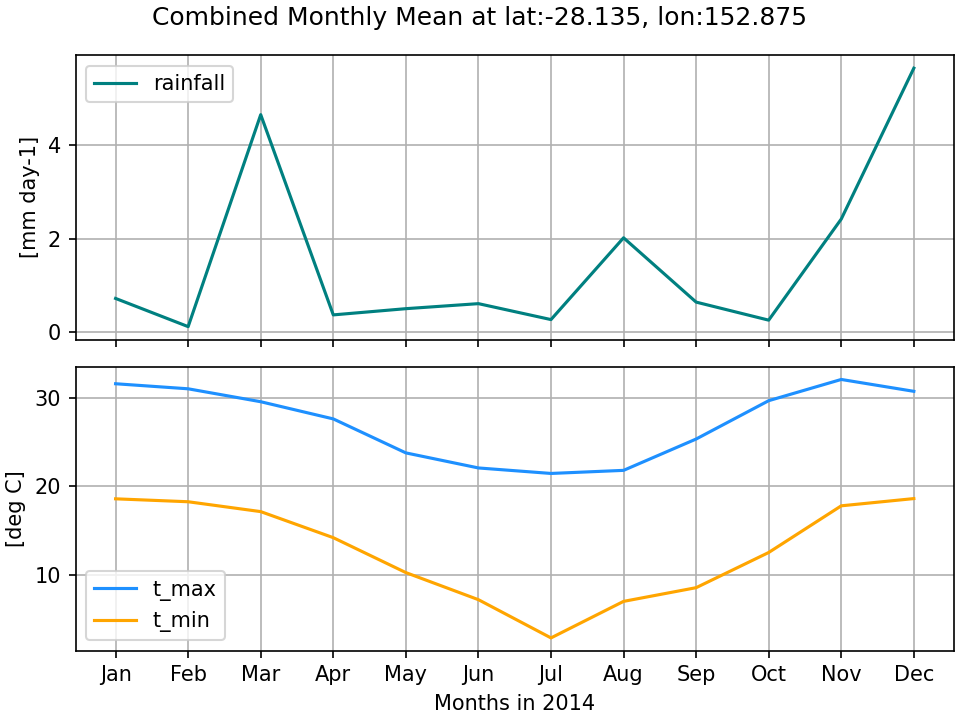

In [32]:
from IPython.display import Image, display

with ZipFile(filepath) as z:
    fp = z.extract('result.png', 'data/outputs')
    display(Image(fp, width=600, height=400)) 


### CSV Results

In [33]:
# now we read the result
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df

,time,lat,lon,rainfall,temp_min,temp_max
0,2014-01-01,-28.135,152.875,0.724762,18.594612,31.622938
1,2014-02-01,-28.135,152.875,0.123242,18.262950,31.050322
2,2014-03-01,-28.135,152.875,4.645188,17.146334,29.586979
3,2014-04-01,-28.135,152.875,0.373490,14.195909,27.641436
4,2014-05-01,-28.135,152.875,0.506197,10.243060,23.794106
5,2014-06-01,-28.135,152.875,0.613396,7.175688,22.089197
6,2014-07-01,-28.135,152.875,0.273421,2.847722,21.467100
7,2014-08-01,-28.135,152.875,2.018164,6.983506,21.816788
8,2014-09-01,-28.135,152.875,0.646114,8.534827,25.364664
9,2014-10-01,-28.135,152.875,0.261359,12.518283,29.705664


## Execute a PreDefined Region Process 

In [34]:
from owslib.wps import WebProcessingService

wps = WebProcessingService('https://api.silvereye.bccvl.org.au/wps', verbose=False, skip_caps=True)

In [35]:
processid = 'one_wps_process'
inputs = [
    ("variables", "temp_max"), ("variables", "temp_min"), ("variables", "rainfall"),
    ("stfn", "mean"),
    ("spatial_selection_type", "predefined_region"),
    ("gdb_name", "ibra7_subregions_states"), 
    ("rec_id", "347_QLD"),
    ("time_selection_type", "one_year_month_range"),
    ("year", "2014"), 
    ("month_min", "4"), ("month_max", "9")   
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

'ProcessAccepted'

In [36]:
monitor_execution(execution, sleepSecs=15, download=True, filepath='data/outputs/out20201015T1120.zip')

Execution status: PyWPS Process started
Execution status: PyWPS Process started
Execution status: process_one_year_month_range 6/36 (16%)
Execution status: process_one_year_month_range 11/36 (30%)
Execution status: process_one_year_month_range 16/36 (44%)
Execution status: process_one_year_month_range 21/36 (58%)
Execution status: process_one_year_month_range 27/36 (75%)
Execution status: process_one_year_month_range 31/36 (86%)
Execution status: process_one_year_month_range 33/36 (91%)
Execution status: PyWPS Process SilverEye combined process for multiple spatial and time selections. finished


## Zip Result

In [37]:
filepath = 'data/outputs/out20201015T1120.zip'

Lets examine the contents of the result.

In [38]:
from zipfile import ZipFile
f = ZipFile(filepath)
print(f.namelist())
f.close()

['result.zarr', 'metadata.json', 'rainfall.csv', 'temp_min.csv', 'temp_min.tif', 'temp_max.tif', 'rainfall.tif', 'temp_max.csv', 'result.csv', 'result.nc']


### Process the NetCDF Results

In [39]:
# now we read the result
import xarray as xr

with ZipFile(filepath) as z:
    with z.open('result.nc') as zf:
        xds = xr.load_dataset(zf.read())
xds

<xarray.Dataset>
Dimensions:      (lat: 183, lon: 73, time: 6)
Coordinates:
  * lat          (lat) float64 -28.18 -28.16 -28.16 ... -26.36 -26.36 -26.34
  * lon          (lon) float64 152.8 152.8 152.8 152.9 ... 153.5 153.5 153.5
  * time         (time) datetime64[ns] 2014-04-01 2014-05-01 ... 2014-09-01
    spatial_ref  int32 0
Data variables:
    rainfall     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    temp_min     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    temp_max     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    geospatial_lat_min:         -28.175
    geospatial_lat_max:         -26.335
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.01
    geospatial_lon_min:         152.825
    geospatial_lon_max:         153.545
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.01
    DOI:                        to be added
    licence_data_access:        These data can be freely downloaded and used
    keywords:                   EARTH SCIENCE > ATMOSPHERE
    summary:                    ANU Daily Data Cubes Sliced and Aggregated
    spatial_coverage:           Australia
    acknowledgement:            The creation of this data was funded by ecoCo...
    title:                      ANU Daily Data Cubes Aggregated
    institution:                Griffith University, Queensland
    contributor_name:           Silvereye, ecoCommons
    license:                    Attribution 4.0 International
    cdm_data_type:              grid
    contact:                    ecocommons@ecocommons.org.au
    source:                     ANUClimate_v1_1
    date_created:               2020-10-27
    publisher_name:             Silvereye microservice, ecoCommons Australia
    publisher_url:              https://ecocommons.org.au
    publisher_email:            ecocommons@ecocommons.org.au
    grid_mapping:               spatial_ref

Notice lots of `NaN` values because the data is clipped to the selected region.

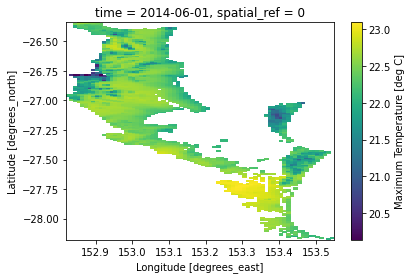

In [40]:
xds['temp_max'].sel({'time': '2014-06-01'}).plot()

### CSV Results

In [41]:
# now we read the result
import pandas as pd

with ZipFile(filepath) as z:
    with z.open('result.csv') as zf:
        df = pd.read_csv(zf)
df.head()

,lat,lon,time,spatial_ref,rainfall,temp_min,temp_max
0,-28.175,152.825,2014-04-01,0,NaN,NaN,NaN
1,-28.175,152.825,2014-05-01,0,NaN,NaN,NaN
2,-28.175,152.825,2014-06-01,0,NaN,NaN,NaN
3,-28.175,152.825,2014-07-01,0,NaN,NaN,NaN
4,-28.175,152.825,2014-08-01,0,NaN,NaN,NaN


### Metadata.json

In [42]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))
    

{
    "spatial_selection_type": "predefined_region",
    "process_name": "process_predefined_region_one_year_month_range",
    "variables": [
        "rainfall",
        "temp_min",
        "temp_max"
    ],
    "time_selection": {
        "yr": 2014,
        "mos": [
            4,
            9
        ],
        "xly": "monthly",
        "stfn": "mean"
    },
    "bounds": {
        "lat_min": -28.17702000000003,
        "lat_max": -26.33033062499999,
        "lon_min": 152.81753281,
        "lon_max": 153.55292
    },
    "predefined_region": {
        "rec_id": "347_QLD",
        "sta_code": "QLD",
        "reg_code": "SEQ",
        "reg_name": "South Eastern Queensland",
        "sub_code": "SEQ04",
        "sub_name": "Sunshine Coast-Gold Coast Lowlands",
        "gdb_name": "ibra7_subregions_states"
    }
}


### Tiff File

In [43]:
import rasterio as rio

with ZipFile(filepath) as z:
    tf = z.extract('temp_max.tif', path='data/outputs')
    rds = rio.open(tf)
        
data = {  # gather all the attrs together
    'meta': rds.meta,
    'bounds': rds.bounds,
    'resolution': rds.res,
    'tags': rds.tags, 
    'indexes': rds.indexes,
    'name': rds.name, 
    'mode': rds.mode
}
data  # notice count: 1, means 1 layer

{'meta': {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': None,
  'width': 73,
  'height': 183,
  'count': 6,
  'crs': CRS.from_epsg(4462),
  'transform': Affine(0.009999999999999985, 0.0, 152.82,
         0.0, 0.010054945054945065, -28.180027472527474)},
 'bounds': BoundingBox(left=152.82, bottom=-26.339972527472526, right=153.54999999999998, top=-28.180027472527474),
 'resolution': (0.009999999999999985, -0.010054945054945065),
 'tags': <function DatasetReader.tags>,
 'indexes': (1, 2, 3, 4, 5, 6),
 'name': 'data/outputs/temp_max.tif',
 'mode': 'r'}

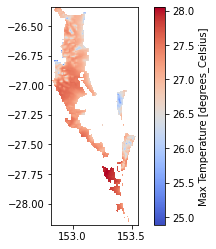

In [44]:
from matplotlib import pyplot
axs = pyplot.imshow(rds.read(1), cmap='coolwarm', origin='lower',
                    extent=(rds.bounds.left, rds.bounds.right, rds.bounds.top, rds.bounds.bottom))
pyplot.colorbar(label='Max Temperature [degrees_Celsius]')
pyplot.show()

### Zarr File

In [45]:
import xarray as xr
import zarr

with ZipFile(filepath) as z:
    zf = z.extract('result.zarr', path='data/outputs')
    store = zarr.ZipStore(zf, mode='r')
    ds = xr.open_zarr(store)
ds

<xarray.Dataset>
Dimensions:   (lat: 183, lon: 73, time: 6)
Coordinates:
  * lat       (lat) float64 -28.18 -28.16 -28.16 -28.14 ... -26.36 -26.36 -26.34
  * lon       (lon) float64 152.8 152.8 152.8 152.9 ... 153.5 153.5 153.5 153.5
  * time      (time) datetime64[ns] 2014-04-01 2014-05-01 ... 2014-09-01
Data variables:
    rainfall  (time, lat, lon) float32 ...
    temp_max  (time, lat, lon) float32 ...
    temp_min  (time, lat, lon) float32 ...
Attributes:
    DOI:                        to be added
    acknowledgement:            The creation of this data was funded by ecoCo...
    cdm_data_type:              grid
    contact:                    ecocommons@ecocommons.org.au
    contributor_name:           Silvereye, ecoCommons
    date_created:               2020-10-27
    geospatial_lat_max:         -26.335
    geospatial_lat_min:         -28.175
    geospatial_lat_resolution:  0.01
    geospatial_lat_units:       degrees_north
    geospatial_lon_max:         153.545
    geospatial_lon_min:         152.825
    geospatial_lon_resolution:  0.01
    geospatial_lon_units:       degrees_east
    grid_mapping:               spatial_ref
    institution:                Griffith University, Queensland
    keywords:                   EARTH SCIENCE > ATMOSPHERE
    licence_data_access:        These data can be freely downloaded and used
    license:                    Attribution 4.0 International
    publisher_email:            ecocommons@ecocommons.org.au
    publisher_name:             Silvereye microservice, ecoCommons Australia
    publisher_url:              https://ecocommons.org.au
    source:                     ANUClimate_v1_1
    spatial_coverage:           Australia
    summary:                    ANU Daily Data Cubes Sliced and Aggregated
    title:                      ANU Daily Data Cubes Aggregated

## Execute a Hand-drawn Polygon Selection Process

A `polygon` selection process requires a `geometry` (polygon) as a parameter. 
The SilverEye Client program allows you to create a hand-drawn polygon and submit it for processing.
Alternatively, you can create and translate a Polygon with a tool such as `shapely`.

In [46]:
from shapely import wkt

with open("data/polygons/peruvian_toquepala.wkt", "r") as f:
    toquepala_geom = wkt.loads(f.read())
toquepala_geom

FileNotFoundError: [Errno 2] No such file or directory: 'data/polygons/peruvian_toquepala.wkt'

In [ ]:
toquepala_geom.wkt[:500]

In [ ]:
# switch to local development server
from owslib.wps import WebProcessingService

wps = WebProcessingService('https://api.silvereye.bccvl.org.au/wps', verbose=False, skip_caps=True)

In [ ]:
processid = 'one_wps_process'
inputs = [
    ("variables", "temp_max"), ("variables", "temp_min"),
    ("stfn", "mean"),
    ("spatial_selection_type", "polygon"),
    ("geometry", toquepala_geom.wkt), 
    ("time_selection_type", "one_year_one_month"),
    ("year", "2014"), ("month", "6")
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

In [ ]:
monitor_execution(execution, sleepSecs=30, download=True, filepath='data/outputs/out20201015T1126.zip')

### ZIP Contents 

In [ ]:
filepath='data/outputs/out20201015T1126.zip'

In [ ]:
from zipfile import ZipFile
f = ZipFile(filepath)
print(f.namelist())
f.close()

### NetCDF Result

In [ ]:
# now we read the result
import xarray as xr

with ZipFile(filepath) as z:
    with z.open('result.nc') as zf:
        xds = xr.load_dataset(zf.read())
xds

In [ ]:
xds['temp_max'].sel({'time': '2014-06-01'}).plot()

### Zarr File

In [ ]:
import xarray as xr
import zarr

with ZipFile(filepath) as z:
    zf = z.extract('result.zarr', path='data/outputs')
    store = zarr.ZipStore(zf, mode='r')
    ds = xr.open_zarr(store)
ds

### Metadata.json

In [ ]:
import json

with ZipFile(filepath) as z:
    with z.open('metadata.json') as zf:
        data = json.load(zf)
        print(json.dumps(data, indent=4))

## One more Example

In [ ]:
from shapely import wkt

with open("data/polygons/mayan_bird.wkt", "r") as f:
    bird_geom = wkt.loads(f.read())
bird_geom

In [ ]:
bird_geom.wkt[:500]

In [ ]:
# switch to local development server
from owslib.wps import WebProcessingService

wps = WebProcessingService('http://localhost:6543/wps', verbose=False, skip_caps=True)

In [ ]:
processid = 'one_wps_process'
inputs = [
    ("variables", "temp_max"), ("variables", "temp_min"),
    ("stfn", "mean"),
    ("spatial_selection_type", "polygon"),
    ("geometry", bird_geom.wkt), 
    ("time_selection_type", "one_year_one_month"),
    ("year", "2014"), ("month", "6")
]
output = "OUTPUT"
execution = wps.execute(processid, inputs, output = "OUTPUT")
execution.getStatus()

In [ ]:
monitor_execution(execution, sleepSecs=30, download=True, filepath='data/outputs/out20200823T1350.zip')

### Zip Contents

In [ ]:
filepath='data/outputs/out20200823T1350.zip'

In [ ]:
from zipfile import ZipFile
f = ZipFile(filepath)
print(f.namelist())
f.close()

### NetCDF Results

In [ ]:
# now we read the result
import xarray as xr

with ZipFile(filepath) as z:
    with z.open('result.nc') as zf:
        xds = xr.load_dataset(zf.read())
xds

In [ ]:
xds['temp_max'].sel({'time': '2014-06-01'}).plot()

## Executing a Pre-made WPS XML Request

In [ ]:
request = open('data/wps/process_years.xml','rb').read()
execution = wps.execute(None, [], request=request)

In [ ]:
monitor_execution(execution, sleepSecs=5, download=True, filepath='data/out55.zip')

In [ ]:
from zipfile import ZipFile
f = ZipFile('data/out55.zip')
print(f.namelist())
f.close()

### Simplified Monitoring - without a Named file download

In [ ]:
request = open('data/wps/process_years.xml','rb').read()
execution = wps.execute(None, [], request=request)
monitor_execution(execution)

Use the Output URL above to download the resulting CSV output file.

In [ ]:
import requests, io 
from zipfile import ZipFile
response = requests.get('https://api.silvereye.bccvl.org.au/outputs/47180400-c031-11ea-b965-ae181de6d2fb/out.zip')
zipinmemory = io.BytesIO(response.content)
f = ZipFile(zipinmemory)
print(f.namelist())
f.close()

response = requests.get('https://api.silvereye.bccvl.org.au/outputs/966b6858-b6d6-11ea-bd85-6a89a330ec88/out.zip')
zipinmemory = io.BytesIO(response.content)
with ZipFile(zipinmemory) as z:
    with z.open('process_temp_max_monthly_mean_2014-Jun.csv') as zf:
        csv_df = pd.read_csv(zf)
csv_df

In [ ]:
response = requests.get('https://api.silvereye.bccvl.org.au/outputs/47180400-c031-11ea-b965-ae181de6d2fb/out.zip')
zipinmemory = io.BytesIO(response.content)
with ZipFile(zipinmemory) as z:
    with z.open('result_monthly_mean_2010-2014.nc') as zf:
        xds2 = xr.load_dataset(zf.read())
xds2

In [ ]:
xds2['temp_max'].sel({'time':'2014-12-01'}).plot(x='lon', y='lat')

In [ ]:
xds2['lon'].values[:3]

In [ ]:
xds2['temp_max'].sel({'lat':-28.235, 'lon':152.865}).plot()